In [6]:
%%capture
!pip install mujoco==2.3.3


## **Importing Required Libraries**

This cell imports all the necessary libraries for implementing **Proximal Policy Optimization (PPO)**. The key components include:

In [7]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal
import torch.nn.functional as F

import torch.optim as optim
import gymnasium as gym
import numpy as np
import os
import pandas as pd

import imageio
from base64 import b64encode
from IPython.display import HTML


import logging
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
import numpy as np

if is_ipython:
    from IPython import display


## **Logging, Visualization, and Video Playback Functions**


In [8]:
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## **Memory Buffer for PPO**

### **Class: `Memory`**
- A **buffer** for storing experiences during training, used for **PPO (Proximal Policy Optimization) updates**.
- Stores the following per episode:
  - `actions`: Actions taken by the agent.
  - `states`: Observed states from the environment.
  - `logprobs`: Log probabilities of actions (needed for importance sampling in PPO).
  - `rewards`: Rewards obtained after taking actions.
  - `state_values`: Estimated state values from the critic.

### **Function: `clear()`**
- Clears the stored experiences before collecting new trajectories.
- Ensures memory is reset between updates to prevent stale data from affecting optimization.


In [9]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]

## **Actor-Critic Network in PPO**

This implementation defines two neural networks used in Proximal Policy Optimization (PPO).

The actor network is responsible for predicting a probability distribution over actions (discrete) or estimating the value for each action (continuous), given the current state, while the critic network evaluates how good the action taken by the actor is, by predicting the reward based on state.

In [10]:
class Actor(nn.Module):
    def __init__(self, state_dim, hidden_size, action_dim):
        super(Actor, self).__init__()
        # Define the Actor architecture
        # TODO
        self.layers = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.mu = nn.Sequential(
            nn.Linear(hidden_size, action_dim),
            nn.Tanh()
        )
        self.std = nn.Linear(hidden_size, action_dim)


    def forward(self, state):
        #TODO
        x = self.layers(state)
        mu = self.mu(x)
        std = F.softplus(self.std(x))

        return mu, std

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size):
        super(Critic, self).__init__()
        # Define the Critic architecture
        #TODO
        self.value = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state):
        # Predict the value of state
        value = self.value(state)
        return value


## **Proximal Policy Optimization (PPO) Algorithm Implementation**

This class implements the **PPO (Proximal Policy Optimization) algorithm**, which is a policy gradient method used in reinforcement learning. It optimizes an actor-critic network while maintaining stability and efficiency.

### **Key Components:**
1. **Initialization (`__init__`)**:
   - Sets hyperparameters (e.g., `gamma`, `eps_clip`, `gae_lambda`).
   - Creates **Actor and Critic networks**.
   - Defines **Adam optimizers** for both networks.
   - Initializes a memory buffer for storing experience.

2. **Action Selection (`select_action`)**:
   - Uses the **Actor network** to predict a mean and standard deviation for the action.
   - Samples an action from a normal distribution.
   - Stores the action, log probability, and value function output in memory.

3. **Policy Evaluation (`evaluate`)**:
   - Computes the log probability of actions under the current policy.
   - Returns entropy (used for exploration encouragement).

4. **Policy Update (`update`)**:
   - Computes **discounted rewards** and **Generalized Advantage Estimation (GAE)**.
   - Uses **clipped surrogate objective** to stabilize training.
   - Minimizes **actor loss** (policy update) and **critic loss** (value function update).
   - Updates networks using **gradient descent**.

5. **Memory Handling (`push_memory`, `load_memory`, `store_reward`)**:
   - Stores and retrieves experience for training updates.
   - Resets the memory buffer after each policy update.

### **Key Features of PPO**
- **Clipping Ratio**: Prevents excessive updates to the policy, improving stability.
- **Advantage Estimation**: Helps in reducing variance in policy updates.
- **Entropy Regularization**: Encourages exploration by adding entropy loss.


## **1. PPO Clipped Loss Function**
The PPO loss function prevents large policy updates by introducing a clipped objective. The ratio of new and old policy probabilities is computed as:
$$
r_t(\theta) = \frac{\pi_{\theta}(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}
$$
where:
- $ \theta $ are the current policy parameters.
- $\theta_{\text{old}} $ are the policy parameters before the update.

The surrogate loss function is:
$$
L^{\text{CLIP}}(\theta) = \mathbb{E} \left[ \min \left( r_t(\theta) A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t \right) \right]
$$
where:
- $ A_t $ is the **advantage function**, which measures how much better an action is compared to the expected value of the state.
- $ \epsilon $ is a small clipping parameter (e.g., **0.2**) that prevents drastic policy updates.

---

## **2. Critic Loss Function**
The critic is updated using **Mean Squared Error (MSE)** between the predicted and actual state value:
$$
L_{\text{critic}} = \mathbb{E} \left[ (V(s_t) - R_t)^2 \right]
$$

---

## **3. Total Loss**
The overall loss function is:
$$
L_{\text{total}} = L^{\text{CLIP}} + \beta H - L_{\text{critic}}
$$
where:
- $ H $ is the **entropy bonus** to encourage exploration.
- $ \beta $ is a small coefficient (e.g., **0.01**) controlling the strength of the entropy bonus.


In [11]:
class PPO(nn.Module):
    def __init__(self, env, config, actor_path=None, critic_path=None):
        super(PPO, self).__init__()
        self.gamma = config.GAMMA
        self.eps_clip = config.EPS_CLIP
        self.epochs = config.K_EPOCHS
        self.gae_lambda = config.GAE
        self.hidden_size = config.hidden_size

        self.lr = config.LEARNING_RATE
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(state_dim, self.hidden_size, action_dim).to(device)
        self.critic = Critic(state_dim, self.hidden_size).to(device)
        if actor_path is not None:
            # print("test")
            self.actor.load_state_dict(torch.load(actor_path, weights_only = True))
        if critic_path is not None:
            self.critic.load_state_dict(torch.load(critic_path, weights_only = True))

        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=self.lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=self.lr)
        self.memory = Memory()

    def select_action(self, state):
        # Save state, action, log probability and state value of current step in the memory buffer.
        # predict the actions by sampling from a normal distribution
        # based on the mean and std calculated by actor
        #TODO
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        mu, std = self.actor(state)
        dist = MultivariateNormal(mu, torch.diag_embed(std**2))
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        value = self.critic(state)

        self.push_memory(state, action, log_prob, value)

        return action.squeeze(0).cpu().numpy()


    def evaluate(self, state, action):
        # evaluate the state value of this state and log probability of choosing this action
        #TODO
        mu, std = self.actor(state)
        dist = MultivariateNormal(mu, torch.diag_embed(std**2))
        action_logprobs = dist.log_prob(action).sum(dim=-1)
        state_value = self.critic(state)
        entropy = dist.entropy().sum(dim=-1)
        return action_logprobs, state_value, entropy

    def update(self):
        discouonted_returns = []
        advantages = []
        discounted_reward = 0
        gae = 0



        # load saved states, actions, log probs, and state values
        #TODO
        old_states, old_actions, old_logprobs, old_state_vals = self.load_memory()


        # Calculate gae for each timestep
        #TODO
        for i in reversed(range(len(self.memory.rewards))):
            discounted_reward = self.memory.rewards[i] + self.gamma * discounted_reward
            discouonted_returns.insert(0, discounted_reward)

        discouonted_returns = torch.tensor(discouonted_returns, dtype=torch.float32, device=device)
        # discouonted_returns = (discouonted_returns - discouonted_returns.mean()) / (discouonted_returns.std() + 1e-7)
        ### changed

        # for i in reversed(range(len(self.memory.rewards) - 1)):
        #     delta = self.memory.rewards[i] + self.gamma * old_state_vals[i + 1] - old_state_vals[i]
        #     gae = delta + self.gamma * self.gae_lambda * gae
        #     advantages.insert(0, gae)
        advantages = discouonted_returns.detach() - old_state_vals.detach()
        # advantages = advantages.unsqueeze(-1)
        ### changed

        advantages = advantages.clone().detach().to(dtype=torch.float32, device=device)
        # advantages = torch.tensor(advantages, dtype=torch.float32, device=device)
        # advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)


        loss_ac = 0
        loss_cri = 0
        for _ in range(self.epochs):
            # calculate logprobs and state values based on the new policy
            #TODO
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)


            # Calculate the loss function and perform the optimization
            #TODO
            ratios = torch.exp(logprobs - old_logprobs.detach())
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1.0 - self.eps_clip, 1.0 + self.eps_clip) * advantages
            loss_actor = -torch.min(surr1, surr2).mean() - 0.01 * dist_entropy.mean()
            # print("discounted_returns:",discouonted_returns)
            loss_critic = 0.5 * F.mse_loss(state_values.squeeze(), discouonted_returns)

            # loss_actor = loss_actor.mean().mean()
            # loss_critic = loss_critic.mean()


            self.optimizer_actor.zero_grad()
            loss_actor.backward(retain_graph=True)
            loss_ac += loss_actor.item()
            self.optimizer_actor.step()

            self.optimizer_critic.zero_grad()
            loss_critic.backward()
            loss_cri += loss_critic.item()
            self.optimizer_critic.step()
        # clear the buffer
        self.memory.clear()
        return loss_ac, loss_cri

    def push_memory(self,state, action, log_prob, value ):
        self.memory.states.append(state)
        self.memory.actions.append(action)
        self.memory.logprobs.append(log_prob)
        self.memory.state_values.append(value)

    def load_memory(self ):
        old_states = torch.stack(self.memory.states).detach()
        old_actions = torch.stack(self.memory.actions).detach()
        old_logprobs = torch.stack(self.memory.logprobs).detach()
        old_state_vals = torch.stack(self.memory.state_values).detach()

        return old_states, old_actions, old_logprobs, old_state_vals

    def store_reward(self, reward):
      self.memory.rewards.append(reward)



## **Configuration Settings for PPO Training**

The `Config` class defines **hyperparameters and settings** for training the PPO agent in a reinforcement learning environment.


In [12]:
class Config:
    # Environment settings
    SEED = 73
    MAX_EPISODES = 2000 #TODO


    # PPO Hyperparameters
    K_EPOCHS = 5
    EPS_CLIP = 0.2
    GAMMA = 0.99
    LEARNING_RATE = 5e-4 #TODO
    BETAS = (0.9, 0.99)

    hidden_size= 64 #TODO
    GAE = 0.95 #TODO

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Proximal Policy Optimization (PPO) Training on HalfCheetah-v4 Environment**

This notebook implements and trains a **Proximal Policy Optimization (PPO)** agent on the **HalfCheetah-v4** environment. The PPO algorithm is an on-policy reinforcement learning method that uses a clipped objective function to update the policy in a stable way.

In [13]:
import json
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config)

# We need to train for many more steps to achieve acceptable results compared to the last environment
actor_losses = []
critic_losses = []
rewards_history = []
sum_of_rewards = []


def save_plot_metrics(path = ""):
    with open(path + "rewards_history.json", "w") as file:
        json.dump(rewards_history, file)
    with open(path + "actor_losses.json", "w") as file:
        json.dump(actor_losses, file)
    with open(path + "critic_losses.json", "w") as file:
        json.dump(critic_losses, file)

def load_plot_metrics(path = ""):
    with open(path + "rewards_history.json", "r") as file:
        rewards_history = json.load(file)
    with open(path + "actor_losses.json", "r") as file:
        actor_losses = json.load(file)
    with open(path + "critic_losses.json", "r") as file:
        critic_losses = json.load(file)

    return rewards_history, actor_losses, critic_losses


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


In [14]:
import json

def train(start_episode, num_episodes, num_trajectories=1, path = ""):
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        # write the training loop
        #TODO
        done = False
        while not done:
            # Select action and get next state and reward
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.store_reward(reward)
            episode_reward += reward
            state = next_state

        if episode % num_trajectories == 0:
            loss_ac, loss_cri = agent.update()
            actor_losses.append(loss_ac)
            critic_losses.append(loss_cri)
            rewards_history.append(episode_reward)

        if (start_episode + episode) % 100 == 0:
            print(f'Episode:{start_episode + episode}->\t Reward:{np.array(rewards_history[-100:]).mean():.2f}->\t actor loss:{loss_ac:.6f},\t critic loss:{loss_cri:.6f}')
            torch.save(agent.actor.state_dict(), path + "actor.pth")
            torch.save(agent.critic.state_dict(), path + "critic.pth")
            save_plot_metrics(path)


    env.close()
    plot_rewards(rewards_history, show_result='PPO agent in HalfCheetah env')


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Episode:0->	 Reward:-423.82->	 actor loss:193.913181,	 critic loss:4365.214783
Episode:100->	 Reward:-558.77->	 actor loss:15.708776,	 critic loss:488.510933
Episode:200->	 Reward:-233.77->	 actor loss:31.113154,	 critic loss:494.972809
Episode:300->	 Reward:-109.69->	 actor loss:-24.665806,	 critic loss:554.201324
Episode:400->	 Reward:198.13->	 actor loss:-35.325938,	 critic loss:568.404129
Episode:500->	 Reward:770.12->	 actor loss:9.589825,	 critic loss:1304.136597
Episode:600->	 Reward:964.35->	 actor loss:-29.712981,	 critic loss:2366.080597
Episode:700->	 Reward:1056.06->	 actor loss:-24.082612,	 critic loss:2346.548798
Episode:800->	 Reward:1032.46->	 actor loss:-76.680175,	 critic loss:2493.145508
Episode:900->	 Reward:1018.53->	 actor loss:-35.753830,	 critic loss:1640.878937


<ipython-input-3-ec46d7d2dbdc>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))


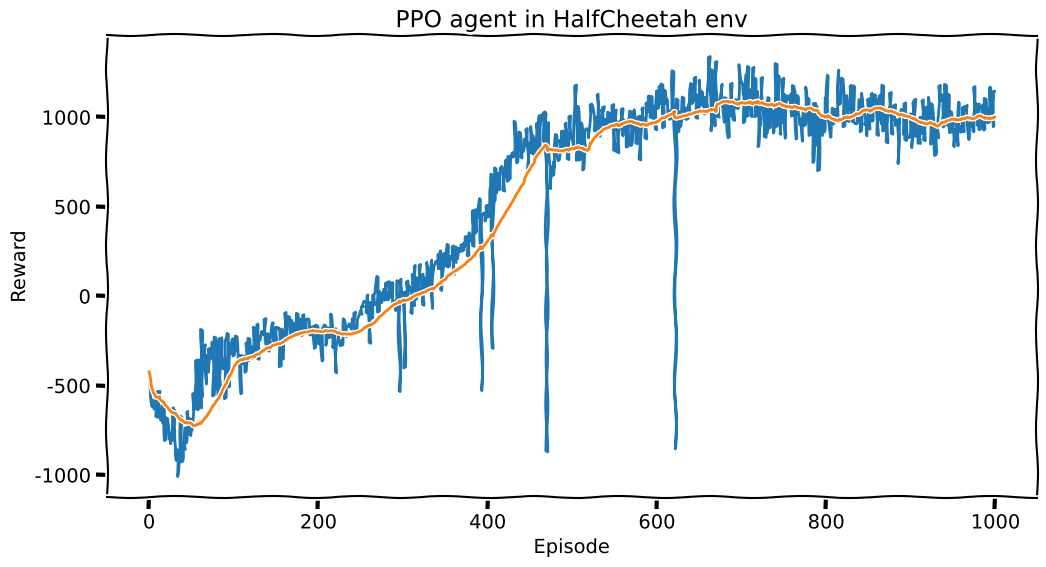

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
path = "checkpoint/"
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config)


actor_losses = []
critic_losses = []
rewards_history = []
sum_of_rewards = []
train(0, 1000, 1, path)

In [ ]:
from google.colab import files

!zip -r p1.zip checkpoint/
files.download("p1.zip")

  adding: checkpoint/ (stored 0%)
  adding: checkpoint/critic_losses.json (deflated 56%)
  adding: checkpoint/actor.pth (deflated 12%)
  adding: checkpoint/critic.pth (deflated 12%)
  adding: checkpoint/rewards_history.json (deflated 50%)
  adding: checkpoint/actor_losses.json (deflated 51%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Episode:1000->	 Reward:1021.44->	 actor loss:-31.478399,	 critic loss:2043.745911
Episode:1100->	 Reward:1135.18->	 actor loss:-19.085540,	 critic loss:1880.647278
Episode:1200->	 Reward:1091.67->	 actor loss:26.385910,	 critic loss:1770.319000
Episode:1300->	 Reward:1079.86->	 actor loss:-10.623868,	 critic loss:2022.539093
Episode:1400->	 Reward:1199.56->	 actor loss:-6.836629,	 critic loss:2515.596039
Episode:1500->	 Reward:1241.64->	 actor loss:-13.020550,	 critic loss:2328.859589
Episode:1600->	 Reward:1160.02->	 actor loss:-7.050447,	 critic loss:2944.905334
Episode:1700->	 Reward:1134.07->	 actor loss:32.616264,	 critic loss:2788.972900
Episode:1800->	 Reward:1142.82->	 actor loss:-66.250930,	 critic loss:2901.663330
Episode:1900->	 Reward:1166.98->	 actor loss:-28.403329,	 critic loss:2711.817383


<ipython-input-8-ec46d7d2dbdc>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))


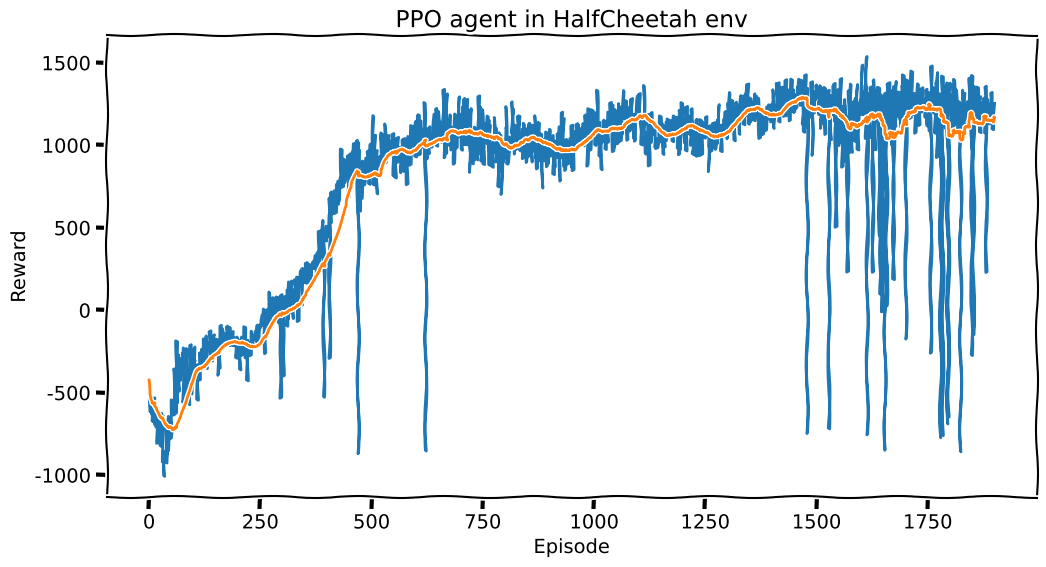

<Figure size 1200x600 with 0 Axes>

updating: checkpoint/ (stored 0%)
updating: checkpoint/critic_losses.json (deflated 59%)
updating: checkpoint/actor.pth (deflated 12%)
updating: checkpoint/critic.pth (deflated 12%)
updating: checkpoint/rewards_history.json (deflated 51%)
updating: checkpoint/actor_losses.json (deflated 52%)


NameError: name 'files' is not defined

<Figure size 1200x600 with 0 Axes>

In [16]:
path = "checkpoint/"
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config, actor_path= path + "actor.pth", critic_path= path + "critic.pth")
agent.memory.clear()

rewards_history, actor_losses, critic_losses = load_plot_metrics(path)


train(len(rewards_history), 1000, 1, path)

!zip -r p1.zip checkpoint/
files.download("p1.zip")

Episode:2000->	 Reward:1184.90->	 actor loss:-41.149919,	 critic loss:3431.611206
Episode:2100->	 Reward:1334.37->	 actor loss:1.322740,	 critic loss:2520.732361
Episode:2200->	 Reward:1296.61->	 actor loss:-46.688672,	 critic loss:2132.767456
Episode:2300->	 Reward:1231.47->	 actor loss:-12.999361,	 critic loss:2124.841919
Episode:2400->	 Reward:1278.36->	 actor loss:77.449462,	 critic loss:4874.624329
Episode:2500->	 Reward:1167.42->	 actor loss:-9.157576,	 critic loss:2145.187317
Episode:2600->	 Reward:1166.37->	 actor loss:-5.148035,	 critic loss:2092.182526
Episode:2700->	 Reward:1269.82->	 actor loss:8.916092,	 critic loss:2298.392029
Episode:2800->	 Reward:1227.18->	 actor loss:16.053862,	 critic loss:2347.026825
Episode:2900->	 Reward:1188.95->	 actor loss:-30.586690,	 critic loss:2865.548096


<ipython-input-8-ec46d7d2dbdc>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))


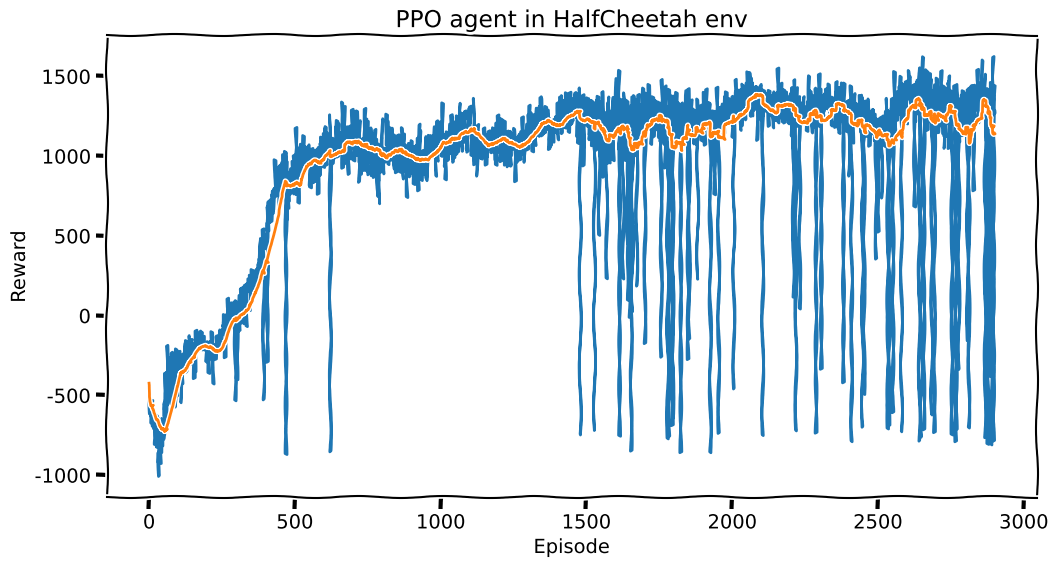

<Figure size 1200x600 with 0 Axes>

updating: checkpoint/ (stored 0%)
updating: checkpoint/critic_losses.json (deflated 61%)
updating: checkpoint/actor.pth (deflated 12%)
updating: checkpoint/critic.pth (deflated 12%)
updating: checkpoint/rewards_history.json (deflated 52%)
updating: checkpoint/actor_losses.json (deflated 52%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1200x600 with 0 Axes>

In [20]:
path = "checkpoint/"
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config, actor_path= path + "actor.pth", critic_path= path + "critic.pth")
agent.memory.clear()

rewards_history, actor_losses, critic_losses = load_plot_metrics(path)


train(len(rewards_history), 1000, 1, path)

!zip -r p1.zip checkpoint/
files.download("p1.zip")

# **Evaluating the PPO Agent in the HalfCheetah-v4 Environment**

In [21]:
# Create environment
%env MUJOCO_GL=egl
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
frames = []

state, info = env.reset()
done = False
total_reward = 0

# run the learned PPO agent to evaluate it
#TODO
while not done:
    # Select action and get next state and reward
    with torch.no_grad():
        action = agent.select_action(state)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    frames.append(env.render())
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward: {total_reward}")

# Save frames as a video
video_path = "./agent_evaluation.mp4"
imageio.mimsave(video_path, frames, fps=25)

# Display the video
show_video(video_path)

env: MUJOCO_GL=egl
Total Reward: 1440.8196143384275
